In [ ]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

#https://www.kaggle.com/code/enigmak/tabnet-deep-neural-network-for-tabular-data

#from base1 import *
from base2 import *

X_train_1 = pd.read_csv('csv/CX_train_eu.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('csv/Cy_train_eu.csv', index_col='Unnamed: 0')
X_val_1 = pd.read_csv('csv/CX_val_eu.csv', index_col='Unnamed: 0')
y_val = pd.read_csv('csv/Cy_val_eu.csv', index_col='Unnamed: 0')
X_test_1 = pd.read_csv('csv/CX_test_eu.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('csv/Cy_test_eu.csv', index_col='Unnamed: 0')

y_train = (y_train['auop']).astype(str)
y_val = (y_val['auop']).astype(str)
y_test = (y_test['auop']).astype(str)

y_train = y_train.replace({'1': 1, '4': 0})
y_val = y_val.replace({'1': 1, '4': 0})
y_test = y_test.replace({'1': 1, '4': 0})

X_train = X_train_1
X_val = X_val_1
X_test = X_test_1

runned!
['PCA', 'SMOTE', 'SimpleImputer', 'StandardScaler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_pca_table', 'np', 'pca_on_train_and_transform_full_data', 'pd', 'plt', 'preprocess_and_apply_smote1', 'remove_outliers_iqr', 'scale_columns1', 'scale_columns2']


<ipython-input-1-377f28dcd7db>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'1': 1, '4': 0})
<ipython-input-1-377f28dcd7db>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = y_val.replace({'1': 1, '4': 0})
<ipython-input-1-377f28dcd7db>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

In [ ]:
# Initialize the label encoder
label_encoder = LabelEncoder()
# Fit the label encoder only on the training set
X_train['X140'] = X_train['X140'].astype(str)  # Ensure it's a string type
X_val['X140'] = X_val['X140'].astype(str)      # Ensure it's a string type
X_test['X140'] = X_test['X140'].astype(str)    # Ensure it's a string type
label_encoder.fit(X_train['X140'])
# Apply the label encoding to all datasets
X_train['X141'] = label_encoder.transform(X_train['X140'])
X_val['X141'] = X_val['X140'].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)
X_test['X141'] = X_test['X140'].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)
# Drop the original 'X140' column
X_train = X_train.drop(columns=['X140'])
X_val = X_val.drop(columns=['X140'])
X_test = X_test.drop(columns=['X140'])

# Fit LabelEncoder on X_train['Country']
label_encoder = LabelEncoder()
label_encoder.fit(X_train['Country'])

# Function to transform with handling for unseen labels
def safe_transform(encoder, values):
    classes = encoder.classes_
    unseen_label = np.max(encoder.transform(classes)) + 1  # Assign a new label for unseen
    value_to_index = {label: idx for idx, label in enumerate(classes)}
    return [value_to_index.get(val, unseen_label) for val in values]

# Transform all sets
X_train['X200'] = label_encoder.transform(X_train['Country'])
X_val['X200'] = safe_transform(label_encoder, X_val['Country'])
X_test['X200'] = safe_transform(label_encoder, X_test['Country'])

# Drop 'Country' column
X_train = X_train.drop(columns=['Country'])
X_val = X_val.drop(columns=['Country'])
X_test = X_test.drop(columns=['Country'])

In [ ]:
# Deal with missing values in the features 
missing_threshold = 0.8
missing_train = X_train.isnull().mean()
cols_to_drop = missing_train[missing_train > missing_threshold].index
# Drop the identified columns from both the training and test sets
X_train = X_train.drop(cols_to_drop, axis=1)
X_val = X_val.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)
print(f"Columns dropped: {list(cols_to_drop)}")
print(len(cols_to_drop))

col_names = X_train.columns.to_list()
col_names.remove("X23")
col_names.remove("X141")
col_names.remove("X200")

# Replace 'inf' and '-inf' with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initialize SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

Columns dropped: ['X20', 'X119']
2


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, precision_recall_curve, auc

# Convert DataFrames to NumPy arrays
X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values

In [ ]:
import torch
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import average_precision_score
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from sklearn.model_selection import train_test_split

In [ ]:
clf_loaded = TabNetClassifier()
clf_loaded.load_model('eu_tabnet_1120.zip')
# # Verify the loaded model
y_pred_loaded = clf_loaded.predict(X_test_np)
print(classification_report(y_test, y_pred_loaded))
y_pred = y_pred_loaded

/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1267
           1       0.90      0.94      0.92      3402

    accuracy                           0.88      4669
   macro avg       0.86      0.84      0.85      4669
weighted avg       0.88      0.88      0.88      4669



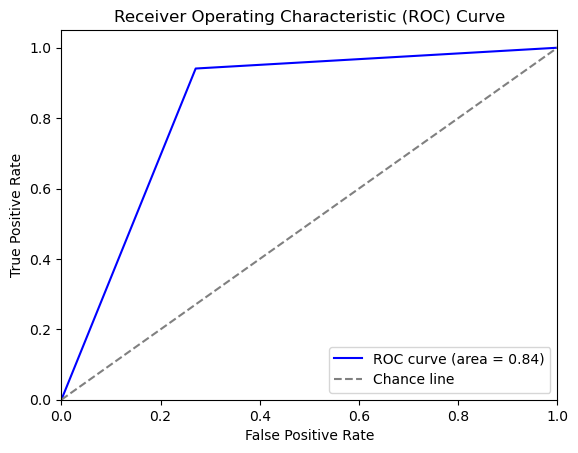

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = y_test
y_pred_proba = y_pred 
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
# plt.savefig("results/241119 EU+C/Plots/TabNet_roc_curve_V20.png", dpi=300, bbox_inches='tight')
plt.show()

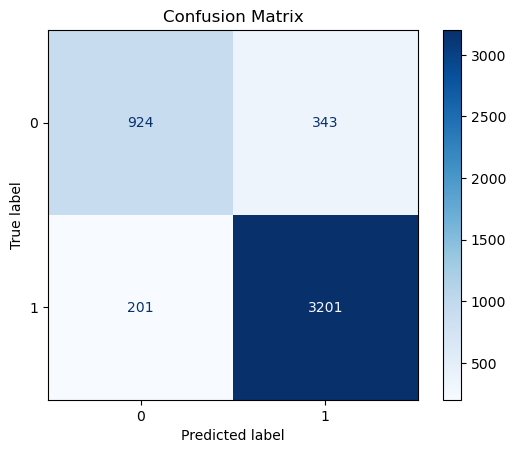

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
# plt.savefig("results/241119 EU+C/Plots/TabNet_confusion_matrix_V20.png", dpi=300, bbox_inches='tight')
plt.show()

Global Feature Importance: [0.21761692 0.2176051  0.21768386 0.21771736 0.21844836 0.21766502
 0.21837734 0.21769434 0.71360334 0.21748299 0.21733865 0.21761268
 0.21770968 0.22779757 0.217219   0.21858633 0.21716651 0.21732485
 0.2168727  0.22010672 0.21747854 0.21765811 0.21721935 0.21709571
 0.21706681 0.21689618 0.2175438  0.21725193 0.21825311 0.21753083
 0.21788477 0.21824896 0.2235449  0.21796819 0.23573687 0.21768884
 0.21736878 0.21728254 0.21747741 0.21747834 0.21746699 0.217209
 0.22082433 0.21681921 0.21763617 0.21714114 0.21758473 0.21715924
 0.21750878 0.21756102 0.21736506 0.21750146 0.21777405 0.21786926
 0.21720937 0.2179194  0.21784049 0.21743945 0.21791725 0.21767794
 0.21715435 0.25674199 0.21738268 0.21967361 0.21733427 0.21792919
 1.60280857 0.21766106 0.21827484 0.21717145 0.21714094 0.21774749
 0.21752884 0.25424418 0.21657769 0.2172097  0.2172238  0.21804377
 0.21743606 0.27244817 0.21778299 0.21791801 0.21779536 0.21681396
 0.2175443  0.21850839]


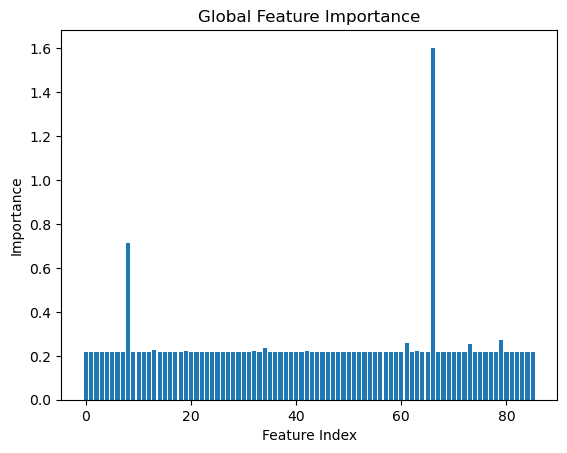

Feature Importances (sorted):
X114: 1.6028085704258561
X10: 0.7136033447920115
X129: 0.2724481693048706
X109: 0.2567419933941487
X123: 0.2542441812543165
X63: 0.23573686521118165
X15: 0.22779756858482125
X61: 0.22354490357188042
X81: 0.2208243258078825
X43: 0.22010671874138446
X111: 0.21967361399233276
X17: 0.21858632923270427
X200: 0.21850839342453618
X6: 0.2184483607583471
X8: 0.21837733682140495
X116: 0.2182748430650095
X53: 0.21825311464590852
X57: 0.21824895907939437
X127: 0.21804376799293287
X62: 0.2179681865762122
X113: 0.21792919412462736
X100: 0.21791940263511794
X131: 0.21791800984410256
X106: 0.21791724711624655
X56: 0.21788477291257102
X98: 0.2178692554196905
X101: 0.21784049346101542
X132: 0.21779536265974817
X130: 0.21778298590653813
X97: 0.2177740530242346
X121: 0.21774749405814534
X5: 0.2177173620431779
X14: 0.2177096803158579
X9: 0.21769433606613062
X64: 0.21768884359992374
X3: 0.2176838599545947
X107: 0.21767793952920855
X7: 0.21766502166661186
X115: 0.217661055533782

In [ ]:
#XAI
import time
# Start the timer
start_time = time.time()
# Get feature importance masks for global interpretability
explain_matrix, masks = clf_loaded.explain(X_test_np)
# Explain matrix provides global feature importance
global_feature_importance = explain_matrix.mean(axis=0)
print("Global Feature Importance:", global_feature_importance)

import matplotlib.pyplot as plt

# Plot feature importance
plt.bar(range(len(global_feature_importance)), global_feature_importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Global Feature Importance")
plt.show()

feature_names = X_test.columns.to_list()
feature_importance_dict = dict(zip(feature_names, global_feature_importance))
# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
# Print sorted feature importances
print("Feature Importances (sorted):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")


# Plot sorted feature importance
sorted_feature_names = [f[0] for f in sorted_features]
sorted_importances = [f[1] for f in sorted_features]
# Plot sorted feature importance
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Global Feature Importance (Sorted)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
# plt.savefig("results/241119 EU+C/Plots/TabNet_global_sorted_V20.png", bbox_inches='tight')
plt.close()



# LOCAL
# Index of the instance to analyze
instance_idx = 0  
# Extract masks for the specific instance
instance_masks = {step: mask[instance_idx, :] for step, mask in masks.items()}
# Aggregate local feature importance
local_feature_importance = sum(mask for mask in instance_masks.values())
# Map to feature names
local_importance_dict = dict(zip(feature_names, local_feature_importance))
# Sort by importance
sorted_local_importance = sorted(local_importance_dict.items(), key=lambda x: x[1], reverse=True)
# Print sorted local feature importances
print(f"Local Feature Importances for Instance {instance_idx} (sorted):")
for feature, importance in sorted_local_importance:
    print(f"{feature}: {importance}")


# Sort features and importances
sorted_local_feature_names = [f[0] for f in sorted_local_importance]
sorted_local_importances = [f[1] for f in sorted_local_importance]
# Plot local feature importance
plt.bar(sorted_local_feature_names, sorted_local_importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title(f"Local Feature Importance for Instance {instance_idx}")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
# plt.savefig(f"results/241119 EU+C/Plots/TabNet_local_instance_{instance_idx}_V20.png", bbox_inches='tight')
plt.close()

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

In [ ]:
def analyze_local_feature_importance(instance_idx, masks, feature_names, save_path=None):
    """
    Analyze and plot local feature importance for a specific instance.

    Parameters:
    - instance_idx (int): Index of the instance to analyze.
    - masks (dict): A dictionary where keys are steps, and values are masks (2D arrays).
    - feature_names (list): List of feature names corresponding to mask columns.
    - save_path (str, optional): Path to save the plot. If None, the plot will not be saved.

    Returns:
    - sorted_local_importance (list of tuples): Sorted local feature importances (feature, importance).
    """
    # Extract masks for the specific instance
    instance_masks = {step: mask[instance_idx, :] for step, mask in masks.items()}
    
    # Aggregate local feature importance
    local_feature_importance = sum(mask for mask in instance_masks.values())
    
    # Map to feature names
    local_importance_dict = dict(zip(feature_names, local_feature_importance))
    
    # Sort by importance
    sorted_local_importance = sorted(local_importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Print sorted local feature importances
    print(f"Local Feature Importances for Instance {instance_idx} (sorted):")
    for feature, importance in sorted_local_importance:
        print(f"{feature}: {importance}")
    
    # Sort features and importances
    sorted_local_feature_names = [f[0] for f in sorted_local_importance]
    sorted_local_importances = [f[1] for f in sorted_local_importance]
    
    # Plot local feature importance
    plt.bar(sorted_local_feature_names, sorted_local_importances)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title(f"Local Feature Importance for Instance {instance_idx}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    # Save plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    
    # Close the plot to free memory
    plt.close()
    
    return sorted_local_importance

In [ ]:
# Local instances
df_conf = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
tp_instance = df_conf[(df_conf['y_true'] == 1) & (df_conf['y_pred'] == 1)].head(1)
fp_instance = df_conf[(df_conf['y_true'] == 0) & (df_conf['y_pred'] == 1)].head(1)
tn_instance = df_conf[(df_conf['y_true'] == 0) & (df_conf['y_pred'] == 0)].head(1)
fn_instance = df_conf[(df_conf['y_true'] == 1) & (df_conf['y_pred'] == 0)].head(1)
tp_iloc = df_conf.index.get_loc(tp_instance.index[0])
fp_iloc = df_conf.index.get_loc(fp_instance.index[0])
tn_iloc = df_conf.index.get_loc(tn_instance.index[0])
fn_iloc = df_conf.index.get_loc(fn_instance.index[0])
# Print instances and their iloc positions
print("True Positive (TP):")
print(tp_instance)
print("Position (iloc):", tp_iloc)
print("\nFalse Positive (FP):")
print(fp_instance)
print("Position (iloc):", fp_iloc)
print("\nTrue Negative (TN):")
print(tn_instance)
print("Position (iloc):", tn_iloc)
print("\nFalse Negative (FN):")
print(fn_instance)
print("Position (iloc):", fn_iloc)

True Positive (TP):
    y_true  y_pred
20       1       1
Position (iloc): 2

False Positive (FP):
    y_true  y_pred
30       0       1
Position (iloc): 12

True Negative (TN):
    y_true  y_pred
21       0       0
Position (iloc): 3

False Negative (FN):
    y_true  y_pred
18       1       0
Position (iloc): 0


In [ ]:
sorted_importances = analyze_local_feature_importance(
    instance_idx= tp_iloc,
    masks=masks,
    feature_names=feature_names,
    save_path=f"results/241120/Plots/TabNet_local_instance_{tp_iloc}_V20.png"  # Optional
)

Local Feature Importances for Instance 2 (sorted):
X81: 0.516695087775588
X10: 0.37944016326218843
X109: 0.3318551992997527
X56: 0.2617011461406946
X61: 0.09477805811911821
X106: 0.09428515378385782
X200: 0.09425623435527086
X121: 0.09396235551685095
X8: 0.0937006063759327
X45: 0.09320760332047939
X57: 0.09318400453776121
X116: 0.09316899999976158
X94: 0.09316360205411911
X13: 0.09291558898985386
X31: 0.09280161093920469
X1: 0.09276535175740719
X72: 0.0927406745031476
X115: 0.09272463992238045
X63: 0.0926516717299819
X43: 0.0926207909360528
X117: 0.09260026924312115
X113: 0.09260000102221966
X111: 0.09250243660062551
X127: 0.09222449827939272
X7: 0.09217198938131332
X9: 0.09210912510752678
X14: 0.09210440702736378
X55: 0.09206870477646589
X3: 0.09206429962068796
X73: 0.09205529652535915
X44: 0.09195966087281704
X101: 0.09192756563425064
X97: 0.09188045840710402
X128: 0.09186363965272903
X93: 0.09179219976067543
X5: 0.0917869582772255
X48: 0.09177655726671219
X131: 0.09176087286323309
X

In [ ]:
sorted_importances = analyze_local_feature_importance(
    instance_idx= fp_iloc,
    masks=masks,
    feature_names=feature_names,
    save_path=f"results/241120/Plots/TabNet_local_instance_{fp_iloc}_V20.png"  # Optional
)

Local Feature Importances for Instance 12 (sorted):
X129: 1.1333015840500593
X97: 0.21505542937666178
X127: 0.15025510359555483
X6: 0.10489866882562637
X200: 0.09344962425529957
X106: 0.09253001399338245
X32: 0.09233316779136658
X121: 0.0922725535929203
X31: 0.09177984297275543
X63: 0.09175271075218916
X8: 0.09113427065312862
X131: 0.0910782441496849
X72: 0.0910689877346158
X101: 0.09106075670570135
X14: 0.09102482255548239
X7: 0.09100991394370794
X43: 0.0908519234508276
X86: 0.09083444345742464
X111: 0.09079010132700205
X95: 0.09078329429030418
X113: 0.09077973011881113
X90: 0.09075876325368881
X61: 0.09075143653899431
X55: 0.09068466071039438
X73: 0.09067944623529911
X2: 0.09065143670886755
X10: 0.09056943003088236
X115: 0.09056394919753075
X5: 0.09054803103208542
X44: 0.0905351024121046
X16: 0.09053485002368689
X126: 0.0905294744297862
X94: 0.09050357807427645
X45: 0.09048924874514341
X1: 0.09046560060232878
X120: 0.09045043401420116
X128: 0.09043715428560972
X130: 0.090364369563758

In [ ]:
sorted_importances = analyze_local_feature_importance(
    instance_idx= tn_iloc,
    masks=masks,
    feature_names=feature_names,
    save_path=f"results/241120/Plots/TabNet_local_instance_{tn_iloc}_V20.png"  # Optional
)

Local Feature Importances for Instance 3 (sorted):
X129: 0.638520167209208
X56: 0.3310060668736696
X109: 0.2248857906088233
X114: 0.21316358633339405
X63: 0.19131187442690134
X43: 0.15710976952686906
X111: 0.14605877548456192
X49: 0.13695790711790323
X123: 0.12830644380301237
X200: 0.09315547905862331
X101: 0.0914331478998065
X7: 0.09053428377956152
X124: 0.0904783746227622
X108: 0.0904664620757103
X15: 0.0902896448969841
X51: 0.09028070513159037
X90: 0.09019515849649906
X16: 0.090190464630723
X10: 0.0901095112785697
X52: 0.09008895326405764
X106: 0.09008821099996567
X130: 0.0900506041944027
X131: 0.08994931727647781
X6: 0.08993708807975054
X1: 0.08992766682058573
X81: 0.08990022516809404
X121: 0.08974719047546387
X14: 0.08970391936600208
X113: 0.08968896698206663
X32: 0.08955924306064844
X53: 0.08953009732067585
X126: 0.08951530884951353
X127: 0.08951372001320124
X5: 0.08943175338208675
X125: 0.08936011791229248
X2: 0.08934327680617571
X8: 0.08924548514187336
X132: 0.08920724410563707

In [ ]:
sorted_importances = analyze_local_feature_importance(
    instance_idx= fn_iloc,
    masks=masks,
    feature_names=feature_names,
    save_path=f"results/241120/Plots/TabNet_local_instance_{fn_iloc}_V20.png"  # Optional
)

Local Feature Importances for Instance 0 (sorted):
X114: 1.012288285419345
X129: 0.3804403329268098
X109: 0.3467006739228964
X56: 0.20993597991764545
X43: 0.12271577719366178
X49: 0.11461534257978201
X63: 0.11449146390077658
X111: 0.10649620834738016
X200: 0.08731053350493312
X106: 0.08677569916471839
X121: 0.08673992985859513
X101: 0.08618220640346408
X8: 0.08601807337254286
X113: 0.08564482815563679
X127: 0.0854322612285614
X15: 0.08534516557119787
X131: 0.08533566142432392
X7: 0.08533410169184208
X130: 0.08529411070048809
X61: 0.08513514441438019
X14: 0.08509501232765615
X31: 0.08501408924348652
X13: 0.08494844031520188
X94: 0.08494167868047953
X1: 0.08494049706496298
X6: 0.08493636175990105
X2: 0.08488457719795406
X95: 0.08485408732667565
X45: 0.08478846307843924
X10: 0.08477296377532184
X5: 0.0847186604514718
X72: 0.08471415680833161
X102: 0.08470792137086391
X132: 0.08467289037071168
X73: 0.08466986450366676
X116: 0.08465086366049945
X44: 0.08464909065514803
X16: 0.08464710484258